# Spectrum Holding Summary Document

Code within notebook tests the shapefile processing to present as human-readable summaries of client number extracts.

In [7]:
# ------------------------------------------------------
# --------------- WORKING DOCUMENT SETUP ---------------
# ------------------------------------------------------

import rrl
import HCIS
import geopandas as gpd

# Test data extract
data = rrl.getSpecData()
clientData, clientSummary = rrl.clientSearch(data, "1104504,20009217")
asmg = gpd.read_file('ASMG/asmg.shp')
gdf = rrl.buildgdf(clientData, asmg)
gdf

,LICENCE_NO,CLIENT_NO,LFREQ_START,LWFREQ_END,HIFREQ_START,HIFREQ_END,LW_BW,HI_BW,BANDWIDTH,AREA_CODE,AREA_NAME,HCIS,geometry
0,10143466,1104504,1920000000,1930000000,2.110000e+09,2.120000e+09,10000000,10000000.0,20000000.0,AP_10143466_4113,Adelaide,"IW3J, IW3K, IW3L, IW3N, IW3O, IW3P, IW6B, IW6C...","POLYGON ((138.08470 -35.16521, 138.08470 -35.0..."
1,10143466,1104504,1935000000,1940000000,2.125000e+09,2.130000e+09,5000000,5000000.0,10000000.0,AP_10143466_4113,Adelaide,"IW3J, IW3K, IW3L, IW3N, IW3O, IW3P, IW6B, IW6C...","POLYGON ((138.08470 -35.16521, 138.08470 -35.0..."
2,10143466,1104504,1920000000,1930000000,2.110000e+09,2.120000e+09,10000000,10000000.0,20000000.0,AP_10143466_4112,Brisbane,"NT9, NT5G, NT5H, NT5K, NT5L, NT5O, NT5P, NT6E,...","POLYGON ((152.50107 -27.91508, 152.50107 -27.8..."
3,10143466,1104504,1935000000,1940000000,2.125000e+09,2.130000e+09,5000000,5000000.0,10000000.0,AP_10143466_4112,Brisbane,"NT9, NT5G, NT5H, NT5K, NT5L, NT5O, NT5P, NT6E,...","POLYGON ((152.50107 -27.91508, 152.50107 -27.8..."
4,10143466,1104504,1960000000,1970000000,2.150000e+09,2.160000e+09,10000000,10000000.0,20000000.0,AP_10143466_4111,Melbourne,"KX3J, KX3K, KX3L, KX3N, KX3O, KX3P, KX6B, KX6C...","POLYGON ((144.08466 -38.49851, 144.08466 -38.4..."
5,10143466,1104504,1935000000,1940000000,2.125000e+09,2.130000e+09,5000000,5000000.0,10000000.0,AP_10143466_4111,Melbourne,"KX3J, KX3K, KX3L, KX3N, KX3O, KX3P, KX6B, KX6C...","POLYGON ((144.08466 -38.49851, 144.08466 -38.4..."
6,10143466,1104504,1935000000,1940000000,2.125000e+09,2.130000e+09,5000000,5000000.0,10000000.0,AP_10143466_4114,Perth,"BV1I, BV1J, BV1K, BV1L, BV1M, BV1N, BV1O, BV1P...","POLYGON ((115.16816 -32.83215, 115.08483 -32.8..."
7,10143466,1104504,1965000000,1975000000,2.155000e+09,2.165000e+09,10000000,10000000.0,20000000.0,AP_10143466_4124,Regional Western Australia,"AU2, AU3, AU6, AU9, AV9, AW3, BU1, BU2, BU4, B...","POLYGON ((114.83486 -34.99884, 114.75153 -34.9..."
8,10143466,1104504,1965000000,1975000000,2.155000e+09,2.165000e+09,10000000,10000000.0,20000000.0,AP_10143466_4119,Regional South East Australia,"NV5K3, NV5L1, NV5L2, NV5L3, NV7A1, LZ2J, LZ2K,...","POLYGON ((138.75139 -36.99856, 138.66805 -36.9..."
9,10143466,1104504,1960000000,1970000000,2.150000e+09,2.160000e+09,10000000,10000000.0,20000000.0,AP_10143466_4118,Sydney,"NV4L8, NV4L9, NV4M2, NV4M3, NV4M5, NV4M6, NV4M...","POLYGON ((150.33451 -34.33176, 150.33451 -34.2..."


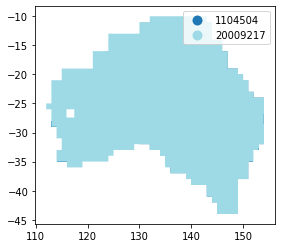

In [8]:
import contextily as cx
from matplotlib import pyplot as plt

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world.name == 'Australia'].plot(color='white', edgecolor='black')
fig = gdf.plot(ax=ax, column='CLIENT_NO', cmap='tab20', categorical=True, legend=True)

c:\Users\navni\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:2352: UserWarning: `keep_geom_type=True` in overlay resulted in 86 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


<AxesSubplot:>

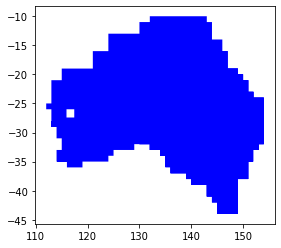

In [9]:
test = gdf.overlay(gdf, how='intersection')
test.plot(color="b")


## Unique Area Function

The most challenging part of generating a holding summary is being able to remove overlapping HCIS cells from each area description entry. Removing overlapping HCIS cells is necessary to produce a two dimensional, human readable dataset.

In [ ]:

def getUniqueAreas(gdf):
    """Given a geodataframe, return a list of unique HCIS descriptions

    Args:
        gdf (GeoDataFrame): Client data geodataframe

    Returns:
        uniqueArea s: List of HCIS descriptions (list)
    """

    # Function Setup
    areaStrings = gdf['AREA_DESCRIPTION'].tolist()
    uniqueAreas = []

    for string in areaStrings:
        uniqueAreas.append(list(string.split(', ')))

    newAreas = []
    i = 0
    
    # Loop through every hcis for comparison
    for hcis1 in uniqueAreas:
        
        j = 0
        
        for hcis2 in uniqueAreas:
            
            # Ensure comparison of different HCIS cells
            if i != j:
                
                union = set(hcis1).intersection(set(hcis2))
                
                # If union is 0, there aren't any matches
                if len(union) == 0:
                    j = j + 1
                    continue
                
                # Duplicate HCIS
                elif set(hcis1) == union:
                    uniqueAreas.pop(j)
                    
                else:
                    newAreas.append(list(union))
                    uniqueAreas[i] = list(set(hcis1) - union)
                    uniqueAreas[j] = list(set(hcis2) - union)
                    
            j = j + 1
            
        i = i + 1

    uniqueAreas.append(newAreas)
    return uniqueAreas

uniqueAreas = getUniqueAreas(shp)
#print(uniqueAreas)

In [ ]:
# Loop testing

newAreas = []
i = 0
# Loop through every hcis for comparison
for hcis1 in uniqueAreas:
    
    j = 0
    
    for hcis2 in uniqueAreas:
        
        # Ensure comparison of different HCIS cells
        if i != j:
            
            union = set(hcis1).intersection(set(hcis2))
            
            # If union is 0, there aren't any matches
            if len(union) == 0:
                j = j + 1
                continue
            
            # Duplicate HCIS
            elif set(hcis1) == union:
                uniqueAreas.pop(j)
                
            else:
                newAreas.append(list(union))
                uniqueAreas[i] = list(set(hcis1) - union)
                uniqueAreas[j] = list(set(hcis2) - union)
                
        j = j + 1
        
    i = i + 1

uniqueAreas.append(newAreas)

uniqueAreas = getUniqueAreas(shp)
print(unique)

## Spectrum Holdings Builder

Using unique area descriptions and client number extract, a new dataset must be constructed summarising holdings for a given unique area description.

In [ ]:
# build gdf from unique areas
bands = set(specLicence['LICENCE_CATEGORY_NAME'])
bands

holdings = pd.DataFrame({
    "HCIS" : [],
    'Total BW' : [],
    '1800 MHz Band' : [],
    '2 GHz Band' : [],
    '2.3 GHz Band' : [],
    '2.5 GHz Band' : [],
    '2.5 GHz Mid Band Gap' : [],
    '20 GHz Defence Band' : [],
    '26 GHz Band' : [],
    '3.4 GHz Band' : [],
    '30 GHz Defence Band' : [],
    '700 MHz Band' : [],
    '800 MHz Band' : [],
    'AWL - FSS Only' : [],
    'AWL - Standard' : []
})
holdings

In [ ]:
# ------------------------------------------------------
# -------- Build holdings helper functions -------------
# ------------------------------------------------------

def intersection (HCIS, row):
    """Returns list of HCIS that is in both input HCIS list and input row.

    Args:
        HCIS (List): List of HCIS identifiers.
        row (Dataframe Row): Row from a client dataframe or shapefile.

    Returns:
        isin (List): List of HCIS identifiers in both inputs.
    """
    temp = set(row['AREA_DESCRIPTION'])
    isin = [value for value in HCIS if value in temp]
    return isin

def removeHCIS (AreaDescription, uaHCIS):
    newHCIS = []
    return newHCIS

def updateHoldings (row, holdings, uaHCIS):
    return

HCIS = uniqueAreas[-1]
print(HCIS)

In [ ]:
# ------------------------------------------------------
# -------- Build holdings primary function -------------
# ------------------------------------------------------

def buildHoldings (uniqueAreas, shp):
    """Given a list of unique area defined by HCIS sequences 
    and a geodataframe, generate a holdings summary.

    Args:
        uniqueAreas (List of Lists): List containing unique HCIS sequences
        shp (Geodataframe): Client Data geodataframe

    Returns:
        holdings: Holdings summary geodataframe
    """
    
    # Create empty dataset
    holdings = pd.DataFrame({
    "HCIS" : [],
    'Total BW' : [],
    '1800 MHz Band' : [],
    '2 GHz Band' : [],
    '2.3 GHz Band' : [],
    '2.5 GHz Band' : [],
    '2.5 GHz Mid Band Gap' : [],
    '20 GHz Defence Band' : [],
    '26 GHz Band' : [],
    '3.4 GHz Band' : [],
    '30 GHz Defence Band' : [],
    '700 MHz Band' : [],
    '800 MHz Band' : [],
    'AWL - FSS Only' : [],
    'AWL - Standard' : []
    })
    
    for uaHCIS in uniqueAreas:
        
        for index, row in shp.iterrows():
            
            isin = intersection(uaHCIS, row)
            
            # If uaHCIS is in entry[HCIS]
            if len(isin) != 0:
                
                shp.at[index]['LICENCE_AREA_DESCRIPTION'] = removeHCIS(shp.iloc[index]['LICENCE_AREA_LOCATION'], uaHCIS)
                
                updateHoldings = (row, holdings, uaHCIS)
            
            else:
                
                continue
            
    return holdings